In [1]:
%matplotlib inline

# Importing modules

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.poly import create_vertice
import re
from datetime import datetime, timedelta

from matplotlib.animation import FuncAnimation
from numpy import arange, isnan, meshgrid, ones

from py_eddy_tracker import start_logger
from py_eddy_tracker.data import get_demo_path
from py_eddy_tracker.dataset.grid import GridCollection, _fit_circle_path
from py_eddy_tracker.observations.observation  import EddiesObservations
from py_eddy_tracker.gui import GUI_AXES
from py_eddy_tracker.generic import uniform_resample, coordinates_to_local
from py_eddy_tracker.poly import create_vertice, poly_area, visvalingam

from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.cm as cm

from typing import List, Tuple

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from py_eddy_tracker.eddy_feature import Amplitude, Contours, detect_local_minima_
import time
from os import walk
from datetime import datetime

# Necessary Classes and function definitions

In [3]:
class eddy_detection():
    def __init__(self, dataset_path: str, lat: list, lon: list, height: str):
        self.path = dataset_path
        self.height = height
        self.data: List[Tuple] = self.load_data()
        self.hours_since_start_list: list = []
        self.grid_list: List[RegularGridDataset] = []
        self.days_list: list = [] 
        self.lat: list = lat
        self.lon: list = lon
        self.anticyclonic_list: list = []
        self.cyclonic_list: list = []
        return None
    
    def start_axes(self, title):
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
        ax.set_xlim(self.lon[0], self.lon[1]), ax.set_ylim(self.lat[0], self.lat[1])
        ax.set_aspect("equal")
        ax.set_title(title, weight="bold")
        return ax


    def update_axes(self, ax, mappable=None):
        ax.grid()
        if mappable:
            plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

    def load_data(self):
        grid_collection = GridCollection.from_netcdf_cube(
            self.path,
            "LONGITUDE",
            "LATITUDE",
            "TIME",
            heigth=self.height)
        return grid_collection.datasets
    
    def create_list_dataset(self, days_list: List):
        self.days_list = days_list
        for day in self.days_list:
            hours, g = self.data[day-1]
            g.vars[self.height] = np.ma.array(g.vars[self.height], mask=np.isnan(g.vars['ssh']))
            g.add_uv(self.height)
            self.hours_since_start_list.append(hours)
            self.grid_list.append(g)

    def plot_graph(self, days:list):
        for day in days:
            ax = self.start_axes("SSH (m)")
            m = self.grid_list[day-1].display(ax, self.height, vmin=-1, vmax=1, cmap="RdBu_r")
            self.update_axes(ax, m)
        return None
    def detect_eddies(self, min_pixel : int = 30):
        for day in self.days_list:
            date = datetime(1950, 1 , 1) + timedelta(hours=int(self.hours_since_start_list[day-1])) 
            a, c = self.grid_list[day-1].eddy_identification(self.height, "u", "v", date, 0.002, pixel_limit=(min_pixel, 2000), shape_error=70)
            self.anticyclonic_list.append(a)
            self.cyclonic_list.append(c)
        return None
    def plot_detected(self, days:list):
        for day in days:
            ax = self.start_axes("Detected Eddies")
            self.anticyclonic_list[day - 1].display(
                ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70
            )
            self.cyclonic_list[day - 1].display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
            ax.legend()
            self.update_axes(ax)
        return None

In [4]:
def all_pixels_below_h0_modified(amp, level):
    """
    Check CSS11 criterion 1: The SSH values of all of the pixels
    are below a given SSH threshold for cyclonic eddies.
    """
    # In some cases pixel value may be very close to the contour bounds
    # All local extrema index on th box
    lmi_i, lmi_j = detect_local_minima_(
        amp.grid_extract.data,
        amp.grid_extract.mask,
        amp.pixel_mask,
        amp.mle,
        1,
    )
    # After we use grid.data because index are in contour and we check before than no pixel are hide
    nb = len(lmi_i)
    if nb == 0:
        print("No extrema found in contour of " + str(amp.nb_pixel) + " pixels")
        return False
    elif nb == 1:
        i, j = lmi_i[0], lmi_j[0]
    else:
        # Verify if several extrema are seriously below contour
        nb_real_extrema = (
            (level - amp.grid_extract.data[lmi_i, lmi_j])
            >= amp.interval_min_secondary
        ).sum()
        if nb_real_extrema > amp.mle:
            print("Extrema > mle")
            return False
        index = amp.grid_extract.data[lmi_i, lmi_j].argmin()
        i, j = lmi_i[index], lmi_j[index]
    amp.amplitude = abs(amp.grid_extract.data[i, j] - amp.h_0)
    (x_start, _), (y_start, _) = amp.contour.bbox_slice
    i += x_start
    j += y_start
    return i, j

In [5]:
def all_pixels_above_h0_modified(amp, level):
    """
    Check CSS11 criterion 1: The SSH values of all of the pixels
    are above a given SSH threshold for anticyclonic eddies.
    """
    # All local extrema index on th box
    lmi_i, lmi_j = detect_local_minima_(
        amp.grid_extract.data,
        amp.grid_extract.mask,
        amp.pixel_mask,
        amp.mle,
        -1,
    )
    # After we use grid.data because index are in contour and we check before than no pixel are hide
    nb = len(lmi_i)
    if nb == 0:
        print("No extrema found in contour of " + str(amp.nb_pixel) + " pixels")
        return False
    elif nb == 1:
        i, j = lmi_i[0], lmi_j[0]
    else:
        # Verify if several extrema are seriously above contour
        nb_real_extrema = (
            (amp.grid_extract.data[lmi_i, lmi_j] - level)
            >= amp.interval_min_secondary
        ).sum()
        if nb_real_extrema > amp.mle:
            print("Extrema > mle")
            return False
        index = amp.grid_extract.data[lmi_i, lmi_j].argmax()
        i, j = lmi_i[index], lmi_j[index]
    amp.amplitude = abs(amp.grid_extract.data[i, j] - amp.h_0)
    (x_start, _), (y_start, _) = amp.contour.bbox_slice
    i += x_start
    j += y_start
    return i, j

In [6]:
def get_amplitude_modified(
        contour, contour_height, data, anticyclonic_search=True, level=None, **kwargs
    ):
        # Instantiate Amplitude object
        amp = Amplitude(
            # Indices of all pixels in contour
            contour=contour,
            # Height of level
            contour_height=contour_height,
            # All grid
            data=data,
            **kwargs,
        )
        if anticyclonic_search:
            reset_centroid = all_pixels_above_h0_modified(amp, level) 
        else:
            reset_centroid = all_pixels_below_h0_modified(amp, level)
        return reset_centroid, amp

In [7]:
def eddy_obs(ssh_class_object, day, seg_data):
    anti_seg_data = seg_data.copy()
    anti_seg_data[anti_seg_data == 1] = 0
    anti_seg_data[anti_seg_data == 0] = 5
    anti_seg_data[anti_seg_data == 2] = 0
    anti_seg_data[anti_seg_data == 5] = 2
    cyc_seg_data = seg_data.copy()
    cyc_seg_data[cyc_seg_data == 2] = 0
    cyc_seg_data[cyc_seg_data == 0] = 5
    cyc_seg_data[cyc_seg_data == 1] = 0
    cyc_seg_data[cyc_seg_data == 5] = 1
    
    regular_grid = ssh_class_object.grid_list[day-1]
    x, y = regular_grid.x_c, regular_grid.y_c
    coord_dict = {}
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            coord_dict[(xi,yi)] = (i,j)
    xx,yy = np.meshgrid(x,y)
    ssh_data = regular_grid.grid("ssh")
    
    a_and_c = list()

    i_x_in = None
    i_y_in = None
    iterator = 1
    index_x = None
    index_y = None
    
    array_variables = [
        "contour_lon_e",
        "contour_lat_e",
        "contour_lon_s",
        "contour_lat_s",
        "uavg_profile",
    ]

    track_extra_variables = [
        "height_max_speed_contour",
        "height_external_contour",
        "height_inner_contour",
        "lon_max",
        "lat_max",
    ]
    
    out_sampling = dict(fixed_size=50)
    resample = visvalingam

    pixel_limit = (30, 2000)
    regular_grid.init_speed_coef("u", "v")


    for anticyclonic_search in [True, False]:
        eddies = []
        coll_idx = 1
        if anticyclonic_search:
            contours = Contours(xx, yy, anti_seg_data.T, (0, 2))
        else:
            contours = Contours(xx, yy, cyc_seg_data.T, (0, 1))

        segments = contours.contours.allsegs
        coll = contours.contours.collections[0]
        contour_paths = coll.get_paths()

        nb_paths = len(contour_paths)


        
        #t0 = time.time()
        k = 0
        if contour_paths:
            for contour in contour_paths:
                index_matrix = np.zeros([1,2], dtype=int)
                
                if contour.used:
                    continue
                    
                
                #np.where(xx == contour.vertices[:,0])[0]
                """
                xx
                [2, 3, 4]
                [2, 3, 4]
                [2, 3, 4]
                
                yy
                [5, 5, 5]
                [6, 6, 6]
                [7, 7, 7]
                
                
                contour.vertices[:,0] = [1,2]
                contour.vertices[:,1] = [5,6]
                
                
                [t, f, f]
                [t, f, f]
                [t, f, f]
                and
                [t, t, t]
                [t, t, t]
                [f, f, f]
                
                we obtain:
                
                [t, f, f]
                [t, f, f]
                [f, f, f]
                
                we want:
                
                [f, f, f]
                [t, f, f]
                [f, f, f]
                
                qww = np.array([xx, yy])
                bool_vert = np.isin(qww, contour.vertices)
                print(xx)
                print(yy)
                print(sum(sum(bool_vert)))
                ssh_data1 = ssh_data.T[bool_vert]
                print(bool_vert.shape)
                print(ssh_data1.shape)
                print(ssh_data1.mean())
                
                
                """
                
                ssh_values_on_contour = np.array([ssh_data[coord_dict[tuple(i)]] for i in contour.vertices])
                avg_ssh = ssh_values_on_contour.mean()
                
#                 print(avg_ssh)
                
                
#                 for i in contour.vertices:
#                     coord_idx = np.argwhere((xx==i[0]) & (yy==i[1]))[0]
#                     index_matrix = np.vstack((index_matrix, coord_idx))
                

#                 index_matrix = index_matrix[1:, :] #Leaving the zeroes which were created during np.zeros
#                 chopped_array = ssh_data.T[tuple(map(tuple, index_matrix.T))]
#                 avg_ssh = chopped_array.mean()
                
#                 print(avg_ssh)

            
                
                
                
                i_x_in, i_y_in = contour.pixels_in(regular_grid)
                (x_start, x_stop), (y_start, y_stop) = contour.bbox_slice
                #contour height and level are same?
                reset_centroid, amp = get_amplitude_modified(contour = contour, contour_height = avg_ssh, anticyclonic_search=anticyclonic_search, data = regular_grid.vars['ssh'], level = avg_ssh, interval = 2)
                
                if (amp.amplitude == 0):
                    continue
                

                if reset_centroid:
                    centi = reset_centroid[0]
                    centj = reset_centroid[1]
                    # To move in regular and unregular grid
                    if len(x.shape) == 1:
                        centlon_e = regular_grid.x_c[centi]
                        centlat_e = regular_grid.y_c[centj]
                    else:
                        centlon_e = regular_grid.x_c[centi, centj]
                        centlat_e = regular_grid.y_c[centi, centj]
                (
                    max_average_speed,
                    speed_contour,
                    inner_contour,
                    speed_array,
                    i_max_speed,
                    i_inner,
                ) = regular_grid.get_uavg(
                    contours,
                    centlon_e,
                    centlat_e,
                    contour,
                    anticyclonic_search,
                    coll_idx,
                    pixel_min=pixel_limit[0],
                )
                obs = EddiesObservations(
                    size=1,
                    track_extra_variables=track_extra_variables,
                    track_array_variables=50,
                    array_variables=array_variables,
                )
                obs.height_max_speed_contour[:] = avg_ssh
                obs.height_external_contour[:] = avg_ssh
                obs.height_inner_contour[:] = avg_ssh
                array_size = speed_array.shape[0]
                obs.nb_contour_selected[:] = array_size
                obs.uavg_profile[:] = speed_array[0]
                obs.amplitude[:] = amp.amplitude
                obs.speed_average[:] = max_average_speed
                obs.num_point_e[:] = contour.lon.shape[0]
                obs.num_point_s[:] = speed_contour.lon.shape[0]


                xy_i = uniform_resample(
                    inner_contour.lon,
                    inner_contour.lat,
                    num_fac=10,
                )
                xy_e = uniform_resample(
                    contour.lon, contour.lat, num_fac=10,
                )
                xy_s = uniform_resample(
                    speed_contour.lon,
                    speed_contour.lat,
                    num_fac=10,
                )


                # First, get position of max SSH based on best fit circle with resampled innermost contour
                centlon_i, centlat_i, _, _ = _fit_circle_path(create_vertice(*xy_i))
                obs.lon_max[:] = centlon_i
                obs.lat_max[:] = centlat_i

                # Second, get speed-based radius, shape error, eddy center, area based on resampled contour of max uavg
                centlon_s, centlat_s, eddy_radius_s, aerr_s = _fit_circle_path(
                    create_vertice(*xy_s)
                )
                obs.radius_s[:] = eddy_radius_s
                obs.shape_error_s[:] = aerr_s
                obs.speed_area[:] = poly_area(
                    *coordinates_to_local(*xy_s, lon0=centlon_s, lat0=centlat_s)
                )
                obs.lon[:] = centlon_s
                obs.lat[:] = centlat_s

                # Third, compute effective radius, shape error, area from resampled effective contour
                _, _, eddy_radius_e, aerr_e = _fit_circle_path(
                    create_vertice(*xy_e)
                )
                obs.radius_e[:] = eddy_radius_e
                obs.shape_error_e[:] = aerr_e
                obs.effective_area[:] = poly_area(
                    *coordinates_to_local(*xy_e, lon0=centlon_s, lat0=centlat_s)
                )

                # Finally, resample contours with output parameters
                xy_e_f = resample(*xy_e, **out_sampling)
                xy_s_f = resample(*xy_s, **out_sampling)
                obs.contour_lon_s[:], obs.contour_lat_s[:] = xy_s_f
                obs.contour_lon_e[:], obs.contour_lat_e[:] = xy_e_f
                eddies.append(obs)
                # To reserve definit ively the area
                #ssh_data.mask[i_x_in, i_y_in] = True
                
        
        #t1 = time.time()

        if len(eddies) == 0:
            eddies = EddiesObservations(
                track_extra_variables=track_extra_variables,
                track_array_variables=1,
                array_variables=array_variables,
            )
        else:
            eddies = EddiesObservations.concatenate(eddies)
        eddies.sign_type = 1 if anticyclonic_search else -1
        eddies.time[:] = int((timedelta(hours=int(ssh_class_object.hours_since_start_list[day-1]))).total_seconds() / 86400.0) #Check this out; produce whole number day
        
        eddies.lon_max[:] %= 360
        eddies.lon[:] %= 360
        ref = eddies.lon - 180
        eddies.contour_lon_e[:] = ((eddies.contour_lon_e.T - ref) % 360 + ref).T
        eddies.contour_lon_s[:] = ((eddies.contour_lon_s.T - ref) % 360 + ref).T
        a_and_c.append(eddies)
        
    return a_and_c
            

   

In [8]:
# #Time fix for SSH using SEG data
# days_dict = {0:0, 1:31, 2:59 ,3:90, 4:120, 5:151, 6:181, 7:212, 8:243, 9:273, 10:304, 11:334, 12:365}
# for j in range(1, 4): #years
#     for i in range(1, 13): #months
#         data_addr_nn = "/home/ollie/ssunar/ssh_filtered/ssh_gridded_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         seg_data_addr_nn = "/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_196"+str(j)+"_001_"+str(i).zfill(2)+"_new.nc"
#         time = None
#         with Dataset(data_addr_nn, "a") as true_ds:
#             with Dataset(seg_data_addr_nn, "r") as seg_ds:
#                 time = seg_ds['TIME'][:]
#             true_ds['TIME'][:] = time
#             #true_ds['TIME'][:] += days_dict[i-1] * 24


# End of the functions and Classes declarations

In [9]:
# Prev Version
# loaded_arr = np.loadtxt("/home/ollie/ssunar/pred_data.out")
# load_original_arr = loaded_arr.reshape(
#     loaded_arr.shape[0], loaded_arr.shape[1] // 480, 480)
# start = 0

# Getting Prediction data in single day format.

In [14]:
pred_seg_data_np = np.load("/albedo/work/user/ssunar/for_paper/segmentation_masks/Gulfstream_pred/pred_data.npy")
    

In [15]:
pred_seg_data_np.shape


(3958, 600, 300)

In [16]:
#Single day gen
file_a_pred_list = []
file_c_pred_list = []
file_a_true_alg_list = []
file_c_true_alg_list = []
start = 0
#2009 to 2019
for kk in range(9, 20):
    for i in range(1, 13):
        if kk == 9 and i <= 2:
            continue
        data_addr_nn = '/albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_20'+str(kk).zfill(2)+'_001_'+str(i).zfill(2)+'.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        ssh_class_object = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon, height = "ssh")
        ssh_class_object.create_list_dataset(days)


        print("last day", last_day)

        true_seg_data_addr = "/albedo/work/user/ssunar/for_paper/segmentation_masks/Gulfstream/seg_mask_gridded_20"+str(kk).zfill(2)+"_001_"+str(i).zfill(2)+"_new.nc"
        true_ds = xr.open_dataset(true_seg_data_addr)
        true_seg_data_month = true_ds.seg_mask.values
        print("true seg shape", true_seg_data_month.shape)

        for j in range(last_day):
            a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=true_seg_data_month[j])
            a = a_and_c[0]
            c = a_and_c[1]
            date = datetime(2000 + kk, i, j+1)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/anticyclonic_alg/Anticyclonic_%Y%m%d.nc"), "w") as h:
                a.to_netcdf(h)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/cyclonic_alg/Cyclonic_%Y%m%d.nc"), "w") as h:
                c.to_netcdf(h)

        for j in range(last_day):
            a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=pred_seg_data_np[start + j])
            a = a_and_c[0]
            c = a_and_c[1]
            date = datetime(2000 + kk, i, j+1)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"), "w") as h:
                file_a_pred_list.append(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/cyclonic_pred/Cyclonic_%Y%m%d.nc"), "w") as h:
                file_c_pred_list.append(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)
        print(start)
        start += last_day

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid i

0


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 13

No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid i

31


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixe

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid i

61


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)


/albedo/home/ssunar/.conda/envs/eddy-tracking/lib/python3.8/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  cumprod = _frommethod('cumprod')


No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixel

No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 10 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid i

92


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 57 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 12 

/tmp/ipykernel_407102/1393379055.py:129: UserWarning: Warning: converting a masked element to nan.
  ssh_values_on_contour = np.array([ssh_data[coord_dict[tuple(i)]] for i in contour.vertices])


No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 7 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid i

122


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 8

No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid i

153


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixe

No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid i

184


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pix

No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pi

No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid i

214


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pix

No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid i

245


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2009_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels


/albedo/home/ssunar/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:1619: RuntimeWarning: overflow encountered in true_divide
  var[:] = data


No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 9 pixe

No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 43 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pi

No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 20 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 

No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixel

No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid i

306


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 

No extrema found in contour of 11 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of

No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid i

337


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pi

No extrema found in contour of 7 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4

No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid i

365


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixe

No extrema found in contour of 31 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10

No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
396


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4

No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 p

No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid i

426


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixe

No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 61 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
457


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 12 pixels
No extrema found in contour

No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 40 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5

No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc


No extrema found in contour of 13 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
487


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 46 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour

No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixel

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
518


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 38 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 p

No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc


No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
549


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 

No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 

No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc


No extrema found in contour of 13 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
579


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixel

No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 9 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 11 pixels
610


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 45 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 26

No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 67 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 14

No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
640


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixe

No extrema found in contour of 6 pixels
No extrema found in contour of 38 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 18 pixels
671


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pix

No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 49 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 43 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pi

No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid i

702


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pi

No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
730


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 

No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
761


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixel

No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
791


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 

No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid i

822


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 p

No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid i

852


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12

No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixel

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid i

883


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 11 pi

No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid i

914


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 6 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 

No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of

No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid i

944


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8

No extrema found in contour of 2 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid i

975


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2011_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 44 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid i

1005


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 40 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 p

No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 

No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 9 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
1036


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_02.nc
We assume pixel position of grid i

last day 29
true seg shape (29, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 23

No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
1067


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
1096


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 27 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pix

No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
1127


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixe

No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc


No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 50 pixels
No extrema found in contour of 11 pixels
1157


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 54 

No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 p

No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 11 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 54 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
1218


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixe

No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
1249


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 p

No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid i

1280


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 35 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 

No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
1310


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixel

No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 10 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
1341


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2012_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 

No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 55 pixels
1371


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 6 p

No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 38 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixel

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc


No extrema found in contour of 7 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
1402


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 2

No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 7 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 16 pixels
1433


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 

No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 p

No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
1461


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 p

No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 5

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
1492


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 16 p

No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 11 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
1522


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 

No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 12 pixels
1553


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 43 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 42 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
1583


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pi

No extrema found in contour of 6 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 20 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc


No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
1614


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 p

No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
1645


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 27 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 

No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc


No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
1675


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc


No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 23 pixels
1706


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2013_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
1736


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pi

No extrema found in contour of 10 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 12 pixels
No extrema found in contou

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
1767


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pix

No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc


No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
1798


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pix

No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 64 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc


No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 19 pixels
1826


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 

No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
1857


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 5 pix

No extrema found in contour of 20 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 43 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 39 pixels
1887


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of

No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pix

No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
1918


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 

No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 9 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
1948


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pi

No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 26 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 

No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
2010


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 11 

No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 1 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc


No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 34 pixels
2040


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 

No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 9 pixels
2071


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2014_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 p

No extrema found in contour of 14 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3

No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 19 pixels
2101


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 

No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
2132


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 64 pixels
No extrema found in contour of 72 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1

No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 19 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
2163


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 

No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
2191


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pix

No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
2222


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 p

No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixel

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
2252


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pix

No extrema found in contour of 9 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 13 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
2283


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 42 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of

No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 14 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 20 pixels
2313


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour o

No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
2344


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 9 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
2375


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pi

No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 55 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 7 pixels
2405


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4

No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc


No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 18 pixels
2436


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2015_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pi

No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
2466


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
2497


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_02.nc
We assume pixel position of grid i

last day 29
true seg shape (29, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pi

No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 10 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc


No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
2528


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 22

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc


No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
2557


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixe

No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 18 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc


No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 33 pixels
2588


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 7 p

No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc


No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
2618


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 23 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16

No extrema found in contour of 29 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 21 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc


No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 17 pixels
2649


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 

No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 27 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc


No extrema found in contour of 15 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
2679


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pi

No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
2710


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixe

No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc


No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
2741


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 24 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
2771


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pix

No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc


No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
2802


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2016_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 

No extrema found in contour of 53 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 20 pixels
2832


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 p

No extrema found in contour of 29 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 1 pixels
2863


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pi

No extrema found in contour of 18 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
2894


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 

No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
2922


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixe

No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
2953


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of

No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 73 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 11 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc


No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
2983


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 25 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4

No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 32 pixels
3014


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 

No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
3044


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 p

No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc


No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
3075


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pix

No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 24 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid i

3106


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1

No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
3136


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5

No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 3 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
3167


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2017_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 23 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 38 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11

No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 p

No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 23 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc


No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
3197


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2

No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc


No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 15 pixels
3228


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
3259


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 20 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 p

No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
3287


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 29 pi

No extrema found in contour of 36 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 50 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc


No extrema found in contour of 13 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
3318


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 4 p

No extrema found in contour of 16 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 57 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 12 pixels
3348


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 47 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 39 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 3 pixels
No extrema found in contour 

No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 41 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 p

No extrema found in contour of 18 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc


No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
3409


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 42 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 31 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1

No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 51 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc


No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
3440


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 4 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 p

No extrema found in contour of 23 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pi

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc


No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
3471


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 p

No extrema found in contour of 14 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc


No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 68 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 13 pixels
3501


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pix

No extrema found in contour of 15 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 33 pixels
No extrema found in contour of 12 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc


No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
3532


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2018_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 44 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pi

No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 

No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 6 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc


No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 3 pixels
3562


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_01.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixe

No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixe

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid i

3593


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_02.nc
We assume pixel position of grid i

last day 28
true seg shape (28, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 42 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 2 

No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 18 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid i

3624


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_03.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 38 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 36 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pix

No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 40 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
3652


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_04.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixel

No extrema found in contour of 20 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc


No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
3683


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_05.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 30 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 

No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 40 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc


No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
3713


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_06.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixe

No extrema found in contour of 10 pixels
No extrema found in contour of 34 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc


No extrema found in contour of 8 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 23 pixels
3744


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_07.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 p

No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 4 pixels
No extrema found in contour o

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc


No extrema found in contour of 16 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 23 pixels
3774


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_08.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 32 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 29 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2

No extrema found in contour of 2 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 24 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 p

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc


No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
3805


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_09.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 28 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8

No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pix

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_10.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixe

No extrema found in contour of 13 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 35 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 42 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 17 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc


No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 15 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 9 pixels
3866


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_11.nc
We assume pixel position of grid i

last day 30
true seg shape (30, 600, 300)
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixe

No extrema found in contour of 37 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 14 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 22 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of

No extrema found in contour of 3 pixels
No extrema found in contour of 13 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 5 

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc


No extrema found in contour of 7 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 27 pixels
No extrema found in contour of 18 pixels
No extrema found in contour of 21 pixels
No extrema found in contour of 5 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 6 pixels
3897


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2019_001_12.nc
We assume pixel position of grid i

last day 31
true seg shape (31, 600, 300)
No extrema found in contour of 1 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 6 pixels
No extrema found in contour of 8 pixel

No extrema found in contour of 4 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 10 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 25 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 1 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 19 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 9 pixels
No extrema found in contour of 3 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 2 pixels
No extrema found in contour of 8 pixels
No extrema found in contour of 1 pi

In [ ]:
file_a_pred_list = []
file_c_pred_list = []
file_a_true_alg_list = []
file_c_true_alg_list = []
start = 0
#2009 to 2019
for kk in range(10, 13):
    for i in range(1, 13):
        if kk == 9 and i <= 2:
            continue
        data_addr_nn = '/albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_20'+str(kk).zfill(2)+'_001_'+str(i).zfill(2)+'.nc'
        ds = xr.open_dataset(data_addr_nn)
        lon = [ds["LONGITUDE"].values.min(), ds["LONGITUDE"].values.max()]
        lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

        last_day = ds["TIME"].size
        days = list(range(1, last_day + 1))
        ssh_class_object = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon, height = "ssh")
        ssh_class_object.create_list_dataset(days)
        ssh_class_object.detect_eddies()


        for j in range(last_day): 
            a = ssh_class_object.anticyclonic_list[j]
            c = ssh_class_object.cyclonic_list[j]
            date = datetime(2000 + kk, i, j+1)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/anticyclonic/Anticyclonic_%Y%m%d.nc"), "w") as h:
                file_a_pred_list.append(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/anticyclonic_alg/Anticyclonic_%Y%m%d.nc"))
                a.to_netcdf(h)
            with Dataset(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/cyclonic/Cyclonic_%Y%m%d.nc"), "w") as h:
                file_c_pred_list.append(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/Gulfstream/cyclonic_alg/Cyclonic_%Y%m%d.nc"))
                c.to_netcdf(h)
        print(start)
        start += last_day

We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_01.nc
We assume pixel position of grid i

0


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_02.nc
We assume pixel position of grid i

31


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_03.nc
We assume pixel position of grid i

59


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_04.nc
We assume pixel position of grid i

90


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_05.nc
We assume pixel position of grid i

120


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_06.nc
We assume pixel position of grid i

151


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_07.nc
We assume pixel position of grid i

181


We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid is centered for /albedo/work/user/ssunar/for_paper/interpolation/Gulfstream/interpolation_2010_001_08.nc
We assume pixel position of grid i

In [12]:
# file_a_pred_list = []
# file_c_pred_list = []
# file_a_true_alg_list = []
# file_c_true_alg_list = []
# start = 0
# for kk in range(1, 2):
#     for i in range(1, 2):
#         data_addr_nn = '/albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_196'+str(kk)+'_001_'+str(i).zfill(2)+'.nc'
#         ds = xr.open_dataset(data_addr_nn)
#         lon = [1, ds["LONGITUDE"].values.max()] #ds["LONGITUDE"].values.min()
#         lat = [ds["LATITUDE"].values.min(), ds["LATITUDE"].values.max()]

#         last_day = ds["TIME"].size
#         days = list(range(1, last_day + 1))
#         ssh_class_object = eddy_detection(dataset_path=data_addr_nn, lat=lat, lon=lon, height = "ssh")
#         ssh_class_object.create_list_dataset(days)


#         print("last day", last_day)

#         true_seg_data_addr = "/albedo/home/ssunar/temp/segmentation_mask_nn_196"+str(kk)+"_001_"+str(i).zfill(2)+".nc"
#         true_ds = xr.open_dataset(true_seg_data_addr)
#         true_seg_data_month = true_ds.seg_mask.values
#         print("true seg shape", true_seg_data_month.shape)

#         for j in range(last_day):
#             a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=true_seg_data_month[j])
#             a = a_and_c[0]
#             c = a_and_c[1]
#             date = datetime(1960 + kk, i, j+1)
#             with Dataset(date.strftime("/albedo/home/ssunar/temp2/Anticyclonic_%Y%m%d.nc"), "w") as h:
#                 a.to_netcdf(h)
#             with Dataset(date.strftime("/albedo/home/ssunar/temp2/Cyclonic_%Y%m%d.nc"), "w") as h:
#                 c.to_netcdf(h)

#         for j in range(last_day):
#             a_and_c =  eddy_obs(ssh_class_object, day = j+1, seg_data=pred_seg_data_np[start + j])
#             a = a_and_c[0]
#             c = a_and_c[1]
#             date = datetime(1960 + kk, i, j+1)
#             with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"), "w") as h:
#                 file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
#                 a.to_netcdf(h)
#             with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"), "w") as h:
#                 file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
#                 c.to_netcdf(h)
#         print(start)
#         start += last_day


We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc
We assume pixel position of grid is centered for /albedo/home/ssunar/ssh_filtered/months/ssh_filtered_gridded_1961_001_01.nc


last day 31
true seg shape (31, 1200, 480)
No extrema found in contour of 26 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 23 pixels
No extrema found in contour of 17 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 16 pixels
No extrema found in contour of 77 pixels
No extrema found in contour of 7 pixels
No extrema found in contour of 26 pixels
No extrema found in contour of 85 pixels
No extrema found in contour of 11 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 81 pixels
No extrema found in contour of 20 pixels
No extrema found in contour of 69 pixels
No extrema found in contour of 40 pixels
No extrema found in contour of 12 pixels
No extrema found in contour of 112 pixels
No extrema found in contour of 118 pixels
No extrema found in contour of 1 pixels
No extrema fou

NameError: name 'pred_seg_data_np' is not defined

# Tracking

## Getting file name list

In [ ]:
month_days = {1: 31, 2: 28, 3: 31, 4: 30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11: 30, 12: 31}
file_a_true_list = []
file_c_true_list = []
file_a_true_alg_list = []
file_c_true_alg_list = []
file_a_pred_list = []
file_c_pred_list = []

#time_val = 4018
for month in range(1, 13):
    for day in range(1, month_days[month]+1):
        date = datetime(1961, month, day)
        
#         #Time fix
        
#         a_true_alg = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"))
#         c_true_alg = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"))
#         a_true = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"))
#         c_true = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"))
#         a_pred = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
#         c_pred = EddiesObservations.load_from_netcdf(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
        
#         a_true_alg.time[:] = time_val
#         c_true_alg.time[:] = time_val
#         a_true.time[:] = time_val
#         c_true.time[:] = time_val
#         a_pred.time[:] = time_val
#         c_pred.time[:] = time_val
        
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"), "w") as h:
#             a_pred.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"), "w") as h:
#             c_pred.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"), "w") as h:
#             a_true_alg.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"), "w") as h:
#             c_true_alg.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"), "w") as h:
#             a_true.to_netcdf(h)
#         with Dataset(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"), "w") as h:
#             c_true.to_netcdf(h)
#         time_val += 1
            
        file_a_true_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true/Anticyclonic_%Y%m%d.nc"))
        file_c_true_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true/Cyclonic_%Y%m%d.nc"))
        file_a_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_true_alg/Anticyclonic_%Y%m%d.nc"))
        file_c_true_alg_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_true_alg/Cyclonic_%Y%m%d.nc"))
        file_a_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
        file_c_pred_list.append(date.strftime("/home/ollie/ssunar/obs_files_days/cyclonic_pred/Cyclonic_%Y%m%d.nc"))    
            
        



In [10]:
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.appli.gui import Anim

In [ ]:
corr = Correspondances(datasets=file_a_true_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
a_true = eddies_default_tracker

corr = Correspondances(datasets=file_c_true_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
c_true = eddies_default_tracker

corr = Correspondances(datasets=file_a_true_alg_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
a_true_alg = eddies_default_tracker

corr = Correspondances(datasets=file_c_true_alg_list, virtual=3)
corr.track()
corr.prepare_merging()
eddies_default_tracker = corr.merge(raw_data=False)
eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
c_true_alg = eddies_default_tracker

# corr = Correspondances(datasets=file_a_pred_list, virtual=3)
# corr.track()
# corr.prepare_merging()
# eddies_default_tracker = corr.merge(raw_data=False)
# eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
# eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
# a_pred = eddies_default_tracker

# corr = Correspondances(datasets=file_c_pred_list, virtual=3)
# corr.track()
# corr.prepare_merging()
# eddies_default_tracker = corr.merge(raw_data=False)
# eddies_default_tracker.virtual[:] = eddies_default_tracker.time == 0
# eddies_default_tracker.filled_by_interpolation(eddies_default_tracker.virtual == 1)
# c_pred = eddies_default_tracker



In [ ]:
a_pred

In [ ]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_true_alg.nb_obs_by_track, c_true_alg.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

In [ ]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_true.nb_obs_by_track, c_true.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

In [ ]:
nb_year = 1
figure = plt.figure(figsize=(12, 8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0, 400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = a_pred.nb_obs_by_track, c_pred.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

# Norm Eddy Lifetime

In [11]:
def sum_profile(x_new, y, out):
    """Will sum all interpolated given array"""
    out += interp(x_new, linspace(0, 1, y.size), y)


class MyObs(TrackEddiesObservations):
    def eddy_norm_lifetime(self, name, nb, factor=1):
        """
        :param str,array name: Array or field name
        :param int nb: size of output array
        """
        y = self.parse_varname(name)
        x = linspace(0, 1, nb)
        out = zeros(nb, dtype=y.dtype)
        nb_track = 0
        for i, b0, b1 in self.iter_on("track"):
            y_ = y[i]
            size_ = y_.size
            if size_ == 0:
                continue
            sum_profile(x, y_, out)
            nb_track += 1
        return x, out / nb_track * factor

In [ ]:
a_true

In [16]:
# with Dataset("/home/ollie/ssunar/temp_dir/a_true_alg.nc", "w") as h:
#     a_true_alg.to_netcdf(h)
# with Dataset("/home/ollie/ssunar/temp_dir/c_true_alg.nc", "w") as h:
#     c_true_alg.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_true_alg_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_true_alg.nc")
c_true_alg_myobs = MyObs.load_file("/home/ollie/ssunar/temp_dir/c_true_alg.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_true_alg_myobs.nb_obs_by_track.max()
nb_max_c = c_true_alg_myobs.nb_obs_by_track.max()

AC_radius_true_alg = a_true_alg_myobs.eddy_norm_lifetime("radius_e", nb=nb_max_a, factor=1e-3)
CC_radius_true_alg = c_true_alg_myobs.eddy_norm_lifetime("radius_e", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_true_alg = a_true_alg_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_true_alg = c_true_alg_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [17]:
# with Dataset("/home/ollie/ssunar/temp_dir/a_true.nc", "w") as h:
#     a_true.to_netcdf(h)
# with Dataset("/home/ollie/ssunar/temp_dir/c_true.nc", "w") as h:
#     c_true.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_true_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_true.nc")
c_true_myobs = MyObs.load_file("/home/ollie/ssunar/temp_dir/c_true.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_true_myobs.nb_obs_by_track.max()
nb_max_c = c_true_myobs.nb_obs_by_track.max()

AC_radius_true = a_true_myobs.eddy_norm_lifetime("radius_e", nb=nb_max_a, factor=1e-3)
CC_radius_true = c_true_myobs.eddy_norm_lifetime("radius_e", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_true = a_true_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_true = c_true_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [ ]:
# with Dataset("/home/ollie/ssunar/temp_dir/a_pred.nc", "w") as h:
#     a_pred.to_netcdf(h)
# with Dataset("/home/ollie/ssunar/temp_dir/c_pred.nc", "w") as h:
#     c_pred.to_netcdf(h)

#kw = dict(include_vars=("speed_radius", "amplitude", "track"))
a_pred_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/a_pred.nc")
c_pred_myobs = MyObs.load_from_netcdf("/home/ollie/ssunar/temp_dir/c_pred.nc")

from numpy import interp, linspace, zeros
nb_max_a = a_pred_myobs.nb_obs_by_track.max()
nb_max_c = c_pred_myobs.nb_obs_by_track.max()

AC_radius_pred = a_pred_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_a, factor=1e-3)
CC_radius_pred = c_pred_myobs.eddy_norm_lifetime("speed_radius", nb=nb_max_c, factor=1e-3)
# Amplitude
AC_amplitude_pred = a_pred_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_a, factor=1e2)
CC_amplitude_pred = c_pred_myobs.eddy_norm_lifetime("amplitude", nb=nb_max_c, factor=1e2)

In [ ]:
a_true_myobs

(Text(0, 0.5, 'Amplitude (cm)'),
 None,
 <matplotlib.legend.Legend at 0x2aac15af3850>)

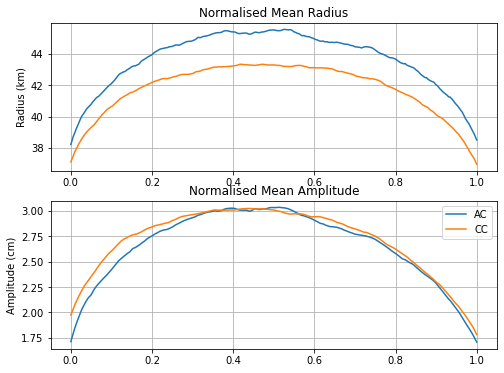

In [18]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_true), ax0.plot(*CC_radius_true)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_true, label="AC"), ax1.plot(*CC_amplitude_true, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

(Text(0, 0.5, 'Amplitude (cm)'),
 None,
 <matplotlib.legend.Legend at 0x2aac15bc47c0>)

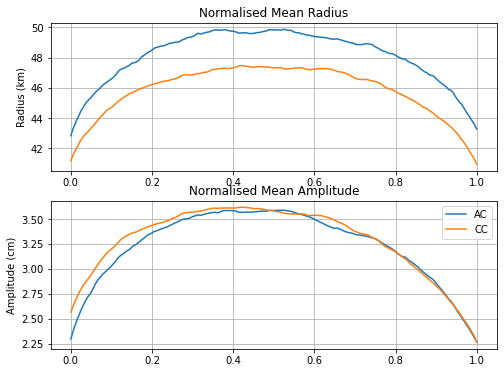

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_true_alg), ax0.plot(*CC_radius_true_alg)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_true_alg, label="AC"), ax1.plot(*CC_amplitude_true_alg, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 6))

ax0.set_title("Normalised Mean Radius")
ax0.plot(*AC_radius_pred), ax0.plot(*CC_radius_pred)
ax0.set_ylabel("Radius (km)"), ax0.grid()
#ax0.set_xlim(0, 1), ax0.set_ylim(0, None)

ax1.set_title("Normalised Mean Amplitude")
ax1.plot(*AC_amplitude_pred, label="AC"), ax1.plot(*CC_amplitude_pred, label="CC")
ax1.set_ylabel("Amplitude (cm)"), ax1.grid(), ax1.legend()
#_ = ax1.set_xlim(0, 1), ax1.set_ylim(0, None)

In [ ]:
# Correspondance class = Track observations
# TrackEddyObservation class = Child class of EddyObservation which has extra attributes of tracking

# EddyObservation -> Correspondance -> TrackEddyObservation

In [ ]:
#why nb conflict for cyclonic eddies
#fix the longitude 
#fix the GUI display type Done
#store in same longitude format
# R- Produce one year of data

In [ ]:
# Fix the true observation data latitude


In [ ]:
temp_eddy = a_true.extract_ids([0]).index(slice(0, 6))

In [ ]:
np.argwhere(a_true.time == 0.0)

In [ ]:
%matplotlib notebook
a = Anim(temp_eddy, sleep_event=0.1, intern=False, figsize=(8, 3.5), cmap="viridis")
a.txt.set_position((-26, -43))
a.show(infinity_loop=False)

In [ ]:
g = GUI(Acyc_default_tracker=eddies_default_tracker)
g.now = 4018
g.bbox = 0, 360, -90, 90
g.adjust()
g.show()

In [ ]:
g.now

In [ ]:
# GUI centered at the region we want
# Statistic 



In [ ]:
# Use the whole process for true segmentation data and compare with the original one.
# 